# Complex Sentiment Index :: creation of indices

In [2]:
coins = [
    'BTC',   # 1
    'ETH',   # 2
    'BNB',   # 3
    'DOT',   # 4
    'SOL',   # 5
    'LUNA',  # 6
    'ADA',   # 7
    'CRO',   # 8
    'AXS',   # 9
    'SAND',  # 10
    'DOGE',  # 11
    'SHIB',  # 12
    'MATIC', # 13
]

In [ ]:
import glob
import pandas as pd

dfs = {}

for coin in coins:
    df_arr = []
    for filepath in glob.iglob(f"tweets/{coin}*.csv"):
        df_arr.append(pd.read_csv(filepath, converters={'orig_id': str}))
    dfs[coin] = pd.concat(df_arr)

In [9]:
dfs['BTC'].head()

id                                               text  \
0  1471283931777581060  Do you believe #Dogezillacoin Can Go $0.000000...   
1  1471283930456227842  #BTC, at a key resistance level now, a rejecti...   
2  1471283924915523587  @maxkeiser There will be a massive blow off to...   
3  1471283923950911488  @Polkadot @substrate_io MISSED #DOGECOIN?? 🐶👀\...   
4  1471283921912569857  @LTLL1000 @ChollimaOrg I found a tool for trad...   

             author_id  retweets  replies  likes  quotes  \
0  1462835764321001474       173        0      0       0   
1   999547624817475584         0        0      0       0   
2           1429142635         0        0      0       0   
3  1435732208480923650         0        0      0       0   
4  1364007131603742813         0        0      0       0   

                 created_at              orig_id           orig_created_at  
0  2021-12-16T00:59:59.000Z  1470884453341876231  2021-12-14T22:32:36.000Z  
1  2021-12-16T00:59:58.000Z                                            NaN  
2  2021-12-16T00:59:57.000Z                                            NaN  
3  2021-12-16T00:59:57.000Z                                            NaN  
4  2021-12-16T00:59:56.000Z                                            NaN

In [ ]:
from transformers import pipeline
from tqdm import trange

classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli', device=0) # to utilise GPU: 

batch_size = 200

In [87]:
sentiments = ['positive', 'negative', 'enthusiastic', 'confused', 'angry', 'sad',
              'greedy', 'fearful', 'shocked', 'hopeful', 'indifferent', 'sarcastic']

def classify(texts, sents):
    hypothesis_template = "This user is feeling {}."
    result = classifier([f"The user said: \"{text}\"" for text in texts], sents, 
                      multi_label=True, hypothesis_template=hypothesis_template, num_workers=0)
    return result

def process(df_orig, sents=sentiments):
    print(sents)
    df = df_orig.copy()
    sent_data = {sent: [] for sent in sents}

    for i in trange(1 + len(df) // batch_size, desc='Scoring sentiments...', ncols=100):
        batch = list(df['text'].iloc[i * batch_size : (i+1) * batch_size])
        for t in classify(batch, sents):
            for sent, score in zip(t['labels'], t['scores']):
                sent_data[sent].append(score)

    for sent in sents:
        df[f"sa/{sent}"] = sent_data[sent]
    
    return df

In [88]:
coin = 'BTC'

dfs[coin] = process(dfs[coin], sents=['positive'])

Scoring sentiments...:   0%|                                                 | 0/46 [00:00<?, ?it/s]

['positive']


C:\Users\Agando\AppData\Roaming\Python\Python37\site-packages\transformers\pipelines\base.py:910: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
Scoring sentiments...: 100%|████████████████████████████████████████| 46/46 [08:47<00:00, 11.46s/it]


In [89]:
import matplotlib.pyplot as plt

sent = 'positive'
col = f"sa/{sent}"

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (6, 4)

dfs[coin][col].hist(bins=50)
plt.legend(loc='best')
plt.title(f"{coin} :: {col}")
plt.show()

No handles with labels found to put in legend.


In [90]:
dfs[coin]

id                                               text  \
0   1471283931777581060  Do you believe #Dogezillacoin Can Go $0.000000...   
1   1471283930456227842  #BTC, at a key resistance level now, a rejecti...   
2   1471283924915523587  @maxkeiser There will be a massive blow off to...   
3   1471283923950911488  @Polkadot @substrate_io MISSED #DOGECOIN?? 🐶👀\...   
4   1471283921912569857  @LTLL1000 @ChollimaOrg I found a tool for trad...   
..                  ...                                                ...   
95  1472642599471443969  Now @BabyDogeCoin trending\nIn #India.... On @...   
96  1472642598569447436  The Piz Bernina  with Ibex is only printed 250...   
97  1472642598049361928  @WatcherGuru #XEC #eCashArmy #eCash \n\nBuy th...   
98  1472642596136579074  #CheemsInu is taking over the crypto space. Th...   
99  1472642592877813761  Now @BabyDogeCoin trending\nIn #India.... On @...   

              author_id  retweets  replies  likes  quotes  \
0   1462835764321001474       173        0      0       0   
1    999547624817475584         0        0      0       0   
2            1429142635         0        0      0       0   
3   1435732208480923650         0        0      0       0   
4   1364007131603742813         0        0      0       0   
..                  ...       ...      ...    ...     ...   
95  1468178103763615751       338        0      0       0   
96  1323914712250228736         0        1      0       1   
97           2414746363         0        0      0       0   
98   928882822693003266         3        0      0       0   
99            603137812       338        0      0       0   

                  created_at              orig_id           orig_created_at  \
0   2021-12-16T00:59:59.000Z  1470884453341876231  2021-12-14T22:32:36.000Z   
1   2021-12-16T00:59:58.000Z                                            NaN   
2   2021-12-16T00:59:57.000Z                                            NaN   
3   2021-12-16T00:59:57.000Z                                            NaN   
4   2021-12-16T00:59:56.000Z                                            NaN   
..                       ...                  ...                       ...   
95  2021-12-19T18:58:50.000Z  1472614655801450504  2021-12-19T17:07:48.000Z   
96  2021-12-19T18:58:50.000Z                                            NaN   
97  2021-12-19T18:58:50.000Z                                            NaN   
98  2021-12-19T18:58:49.000Z  1472640306067738632  2021-12-19T18:49:43.000Z   
99  2021-12-19T18:58:49.000Z  1472614655801450504  2021-12-19T17:07:48.000Z   

    sa/positive  hour_id  
0      0.148521   455448  
1      0.001939   455448  
2      0.008801   455448  
3      0.009466   455448  
4      0.156399   455448  
..          ...      ...  
95     0.901920   455538  
96     0.639356   455538  
97     0.327293   455538  
98     0.990364   455538  
99     0.901920   455538  

[9100 rows x 12 columns]

In [91]:
dfs[coin]['hour_id'] = pd.to_datetime(dfs[coin]['created_at']).astype('int64') // 10**9 // 3600

In [92]:
dfi = {sent: {}}

dfi[sent][coin] = pd.DataFrame(dfs[coin].groupby('hour_id')[col].agg('mean'))

In [93]:
from datetime import timedelta

dfi[sent][coin]['dt'] = pd.to_datetime(dfi[sent][coin].index * 3600 * 10**9) + timedelta(hours=1)
dfi[sent][coin] = dfi[sent][coin].set_index('dt')
dfi[sent][coin]

sa/positive
dt                              
2021-12-16 01:00:00     0.646919
2021-12-16 02:00:00     0.566403
2021-12-16 03:00:00     0.599624
2021-12-16 04:00:00     0.607243
2021-12-16 05:00:00     0.653454
...                          ...
2021-12-19 15:00:00     0.619185
2021-12-19 16:00:00     0.655021
2021-12-19 17:00:00     0.685695
2021-12-19 18:00:00     0.609174
2021-12-19 19:00:00     0.660692

[91 rows x 1 columns]

<AxesSubplot:xlabel='dt'>

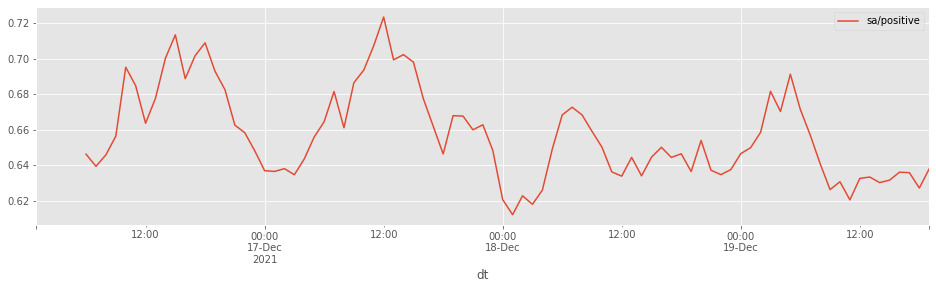

In [96]:
plt.rcParams["figure.figsize"] = (16, 4)

dfi[sent][coin].rolling(window=6).mean().plot()

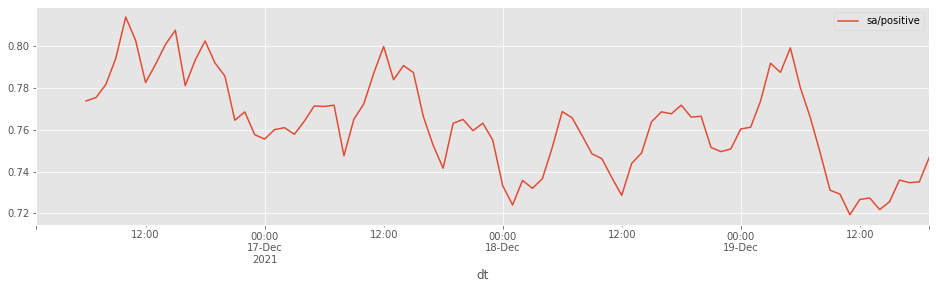